# Prepare Data

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import datetime,timedelta

In [2]:
file_suffix = '.csv' # format of target data file
path = '../data/dataSets/training/' # path to target data file
filename = 'volume(table 6)_training' # target data file name

In [3]:
# Aggregate valume data into 20 minutes time window
# Reference from: https://github.com/chenzeyuczy/KDD2017/blob/master/scripts/aggregate_volume.py
# output: .csv file at current directory

def avgVolume(in_file):

    out_suffix = '_20min_avg_volume'
    in_file_name = in_file + file_suffix
    out_file_name = in_file.split('_')[1] + out_suffix + file_suffix

    # Step 1: Load volume data
    fr = open(path + in_file_name, 'r')
    fr.readline()  # skip the header
    vol_data = fr.readlines()
    fr.close()

    # Step 2: Create a dictionary to caculate and store volume per time window
    volumes = {}  # key: time window value: dictionary
    for i in range(len(vol_data)):
        each_pass = vol_data[i].replace('"', '').split(',')
        tollgate_id = each_pass[1]
        direction = each_pass[2]

        pass_time = each_pass[0]
        pass_time = datetime.strptime(pass_time, "%Y-%m-%d %H:%M:%S")
        time_window_minute = int(math.floor(pass_time.minute / 20) * 20)
        #print pass_time
        start_time_window = datetime(pass_time.year, pass_time.month, pass_time.day,
                                     pass_time.hour, time_window_minute, 0)

        if start_time_window not in volumes:
            volumes[start_time_window] = {}
        if tollgate_id not in volumes[start_time_window]:
            volumes[start_time_window][tollgate_id] = {}
        if direction not in volumes[start_time_window][tollgate_id]:
            volumes[start_time_window][tollgate_id][direction] = 1
        else:
            volumes[start_time_window][tollgate_id][direction] += 1

    # Step 3: format output for tollgate and direction per time window
    fw = open(out_file_name, 'w')
    fw.writelines(','.join(['"tollgate_id"', '"time_window"', '"direction"', '"volume"']) + '\n')
    time_windows = list(volumes.keys())
    time_windows.sort()
    for time_window_start in time_windows:
        time_window_end = time_window_start + timedelta(minutes=20)
        for tollgate_id in volumes[time_window_start]:
            for direction in volumes[time_window_start][tollgate_id]:
               out_line = ','.join(['"' + str(tollgate_id) + '"', 
                                 '"[' + str(time_window_start) + ',' + str(time_window_end) + ')"',
                                 '"' + str(direction) + '"',
                                 '"' + str(volumes[time_window_start][tollgate_id][direction]) + '"',
                               ]) + '\n'
               fw.writelines(out_line)
    fw.close()

In [4]:
# Load and convert phase 1 training data and save into training_20min_avg_volume.csv

avgVolume(filename)

In [5]:
df = pd.read_csv('training_20min_avg_volume.csv')
df.shape

(10063, 4)

In [6]:
df.head() # Start date/time of training data set

,tollgate_id,time_window,direction,volume
0,3,"[2016-09-19 00:00:00,2016-09-19 00:20:00)",0,17
1,3,"[2016-09-19 00:00:00,2016-09-19 00:20:00)",1,181
2,1,"[2016-09-19 00:00:00,2016-09-19 00:20:00)",0,13
3,1,"[2016-09-19 00:00:00,2016-09-19 00:20:00)",1,140
4,2,"[2016-09-19 00:00:00,2016-09-19 00:20:00)",0,2


In [7]:
df.tail() # End date/time of training data set

,tollgate_id,time_window,direction,volume
10058,2,"[2016-10-17 23:40:00,2016-10-18 00:00:00)",0,18
10059,3,"[2016-10-17 23:40:00,2016-10-18 00:00:00)",0,15
10060,3,"[2016-10-17 23:40:00,2016-10-18 00:00:00)",1,22
10061,1,"[2016-10-17 23:40:00,2016-10-18 00:00:00)",0,2
10062,1,"[2016-10-17 23:40:00,2016-10-18 00:00:00)",1,10


# Study Data

In [8]:
tollgate_1_direction_0 = df[df['tollgate_id'] == 1][df['direction'] == 0]
tollgate_1_direction_0.shape

D:\anaconda\conda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(2084, 4)

In [9]:
tollgate_1_direction_0.head()

,tollgate_id,time_window,direction,volume
2,1,"[2016-09-19 00:00:00,2016-09-19 00:20:00)",0,13
5,1,"[2016-09-19 00:20:00,2016-09-19 00:40:00)",0,6
11,1,"[2016-09-19 00:40:00,2016-09-19 01:00:00)",0,9
16,1,"[2016-09-19 01:00:00,2016-09-19 01:20:00)",0,10
18,1,"[2016-09-19 01:20:00,2016-09-19 01:40:00)",0,14


In [10]:
tollgate_1_direction_1 = df[df['tollgate_id'] == 1][df['direction'] == 1]
tollgate_1_direction_1.shape

D:\anaconda\conda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(2084, 4)

In [11]:
tollgate_1_direction_1.head()

,tollgate_id,time_window,direction,volume
3,1,"[2016-09-19 00:00:00,2016-09-19 00:20:00)",1,140
6,1,"[2016-09-19 00:20:00,2016-09-19 00:40:00)",1,56
12,1,"[2016-09-19 00:40:00,2016-09-19 01:00:00)",1,31
17,1,"[2016-09-19 01:00:00,2016-09-19 01:20:00)",1,4
19,1,"[2016-09-19 01:20:00,2016-09-19 01:40:00)",1,14


In [12]:
tollgate_2_direction_0 = df[df['tollgate_id'] == 2][df['direction'] == 0]
tollgate_2_direction_0.shape

D:\anaconda\conda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(1724, 4)

In [13]:
tollgate_2_direction_0.head()

,tollgate_id,time_window,direction,volume
4,2,"[2016-09-19 00:00:00,2016-09-19 00:20:00)",0,2
15,2,"[2016-09-19 01:00:00,2016-09-19 01:20:00)",0,1
22,2,"[2016-09-19 01:40:00,2016-09-19 02:00:00)",0,2
64,2,"[2016-09-19 05:00:00,2016-09-19 05:20:00)",0,14
71,2,"[2016-09-19 05:20:00,2016-09-19 05:40:00)",0,12


In [14]:
tollgate_3_direction_0 = df[df['tollgate_id'] == 3][df['direction'] == 0]
tollgate_3_direction_0.shape

D:\anaconda\conda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(2086, 4)

In [15]:
tollgate_3_direction_0.head()

,tollgate_id,time_window,direction,volume
0,3,"[2016-09-19 00:00:00,2016-09-19 00:20:00)",0,17
7,3,"[2016-09-19 00:20:00,2016-09-19 00:40:00)",0,16
9,3,"[2016-09-19 00:40:00,2016-09-19 01:00:00)",0,16
13,3,"[2016-09-19 01:00:00,2016-09-19 01:20:00)",0,17
20,3,"[2016-09-19 01:20:00,2016-09-19 01:40:00)",0,17


In [16]:
tollgate_3_direction_1 = df[df['tollgate_id'] == 3][df['direction'] == 1]
tollgate_3_direction_1.shape

D:\anaconda\conda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(2085, 4)

In [17]:
tollgate_3_direction_1.head()

,tollgate_id,time_window,direction,volume
1,3,"[2016-09-19 00:00:00,2016-09-19 00:20:00)",1,181
8,3,"[2016-09-19 00:20:00,2016-09-19 00:40:00)",1,112
10,3,"[2016-09-19 00:40:00,2016-09-19 01:00:00)",1,93
14,3,"[2016-09-19 01:00:00,2016-09-19 01:20:00)",1,4
21,3,"[2016-09-19 01:20:00,2016-09-19 01:40:00)",1,5


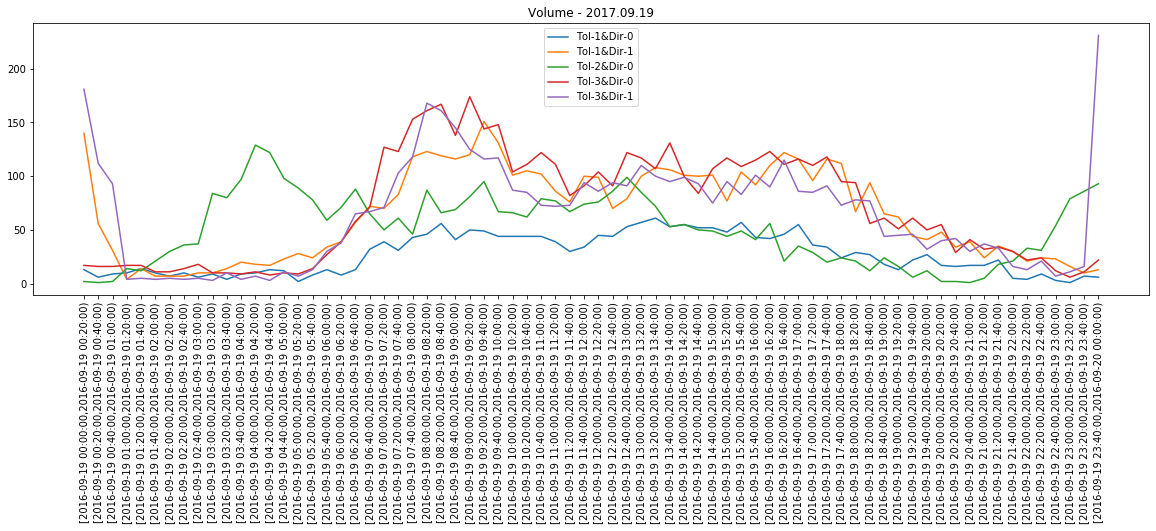

In [18]:
# Vosualize data pattern
plt.figure(figsize=(20,5))

xticks = tollgate_1_direction_0['time_window'].values
plt.plot(xticks[:72], tollgate_1_direction_0['volume'][:72], label='Tol-1&Dir-0')
plt.plot(xticks[:72], tollgate_1_direction_1['volume'][:72], label='Tol-1&Dir-1')
plt.plot(xticks[:72], tollgate_2_direction_0['volume'][:72], label='Tol-2&Dir-0')
plt.plot(xticks[:72], tollgate_3_direction_0['volume'][:72], label='Tol-3&Dir-0')
plt.plot(xticks[:72], tollgate_3_direction_1['volume'][:72], label='Tol-3&Dir-1')
plt.xticks(xticks[:72], xticks[:72], rotation='vertical')
plt.title('Volume - 2017.09.19')
plt.legend()
plt.show()

In [19]:
# Get month and day
df['month'] = df['time_window'].str.slice(6,8)
df['day'] = df['time_window'].str.slice(9,11)
df.head()

,tollgate_id,time_window,direction,volume,month,day
0,3,"[2016-09-19 00:00:00,2016-09-19 00:20:00)",0,17,09,19
1,3,"[2016-09-19 00:00:00,2016-09-19 00:20:00)",1,181,09,19
2,1,"[2016-09-19 00:00:00,2016-09-19 00:20:00)",0,13,09,19
3,1,"[2016-09-19 00:00:00,2016-09-19 00:20:00)",1,140,09,19
4,2,"[2016-09-19 00:00:00,2016-09-19 00:20:00)",0,2,09,19


In [20]:
# Aggregate on Volume based on date
v_day = df.groupby(['month','day','tollgate_id','direction'], as_index=False).sum()
v_day['date'] = v_day['month'].map(str) + '-' + v_day['day'].map(str) 
v_day.head()

,month,day,tollgate_id,direction,volume,date
0,09,19,1,0,1969,09-19
1,09,19,1,1,4732,09-19
2,09,19,2,0,3297,09-19
3,09,19,3,0,5037,09-19
4,09,19,3,1,4529,09-19


D:\anaconda\conda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
D:\anaconda\conda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
D:\anaconda\conda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
D:\anaconda\conda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
D:\anaconda\conda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


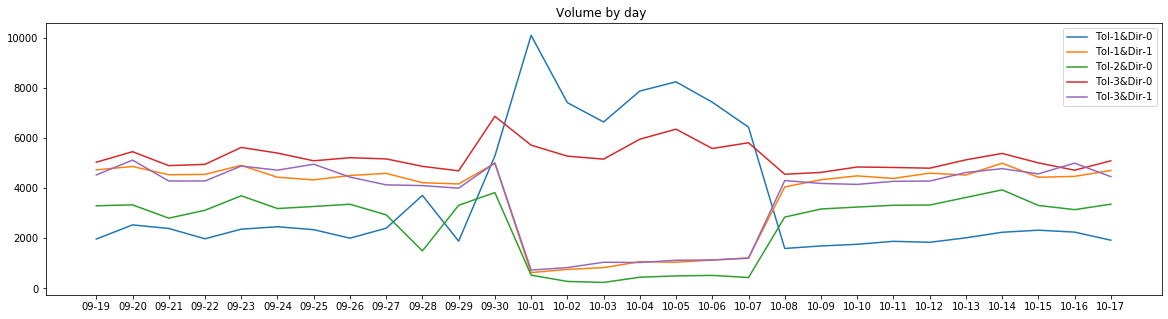

In [21]:
# Visualize volume change throughout the training period
# Observed significant inregularity int the National Day Holiday period

v_day_tollgate_1_direction_0 = v_day[v_day['tollgate_id'] == 1][v_day['direction'] == 0]
v_day_tollgate_1_direction_1 = v_day[v_day['tollgate_id'] == 1][v_day['direction'] == 1]
v_day_tollgate_2_direction_0 = v_day[v_day['tollgate_id'] == 2][v_day['direction'] == 0]
v_day_tollgate_3_direction_0 = v_day[v_day['tollgate_id'] == 3][v_day['direction'] == 0]
v_day_tollgate_3_direction_1 = v_day[v_day['tollgate_id'] == 3][v_day['direction'] == 1]

plt.figure(figsize=(20,5))
xticks = v_day_tollgate_1_direction_0['date'].values

plt.plot(xticks, v_day_tollgate_1_direction_0['volume'], label='Tol-1&Dir-0')
plt.plot(xticks, v_day_tollgate_1_direction_1['volume'], label='Tol-1&Dir-1')
plt.plot(xticks, v_day_tollgate_2_direction_0['volume'], label='Tol-2&Dir-0')
plt.plot(xticks, v_day_tollgate_3_direction_0['volume'], label='Tol-3&Dir-0')
plt.plot(xticks, v_day_tollgate_3_direction_1['volume'], label='Tol-3&Dir-1')

plt.title('Volume by day ')
plt.legend()
plt.show()

# Predict and Evaluate

In [22]:
# Split time window field and format it to YYYY-mm-dd HH:MM:SS
# Reference from: https://github.com/chenzeyuczy/KDD2017/blob/master/code/load_data.py

def parse_avg_volume(filename):
    df = pd.read_csv(filename)

    # Convert data format.
    df['time_window'] = df['time_window'].apply(lambda x: x.split(',')[0].strip('['))
    df['time_window'] = pd.to_datetime(df['time_window'], format="%Y-%m-%d %H:%M:%S")

    return df

In [23]:
# Load Testing Dataset
file_suffix = '.csv'
path = '../data/dataSet_phase2/'
filename = 'volume(table 6)_training2'

avgVolume(filename)

In [24]:
avg_volume_train = parse_avg_volume('training_20min_avg_volume.csv')
avg_volume_train.head()

,tollgate_id,time_window,direction,volume
0,3,2016-09-19,0,17
1,3,2016-09-19,1,181
2,1,2016-09-19,0,13
3,1,2016-09-19,1,140
4,2,2016-09-19,0,2


In [25]:
avg_volume_test = parse_avg_volume('training2_20min_avg_volume.csv')
avg_volume_test.head()

,tollgate_id,time_window,direction,volume
0,3,2016-10-18 00:00:00,0,12
1,3,2016-10-18 00:00:00,1,148
2,1,2016-10-18 00:00:00,0,11
3,1,2016-10-18 00:00:00,1,105
4,3,2016-10-18 00:20:00,0,12


In [26]:
# Extract month/day/dayofweek/hour/minute/holiday features from time window
# Reference from: https://github.com/chenzeyuczy/KDD2017/blob/master/code/train_xgb.py

def convert_dataframe(dataframe):
    df = dataframe.copy()

    # Process date field.
    df['month'] = df['time_window'].apply(lambda x: x.month)
    df['day'] = df['time_window'].apply(lambda x: x.day)
    df['weekday'] = df['time_window'].apply(lambda x: x.dayofweek)
    df['hour'] = df['time_window'].apply(lambda x: x.hour)
    df['minute'] = df['time_window'].apply(lambda x: x.minute)
    df['holiday'] = df['time_window'].apply(lambda x: is_holiday(x))

    # Drop unused field.
    df.drop(['time_window'], axis=1, inplace=True)
    return df

In [27]:
# Check if the day is holiday
# https://github.com/chenzeyuczy/KDD2017/blob/master/code/tools.py

def is_holiday(date_time):

    # Mid-Autumn Festival.
    if date_time.month == 9 and date_time.day >= 15 and date_time.day <= 17:
        return 1
    # National Day.
    elif date_time.month == 10 and date_time.day >= 1 and date_time.day <= 7:
        return 1
    return 0

In [28]:
train_df = avg_volume_train.copy()
train_df = convert_dataframe(train_df)
train_df.head()

,tollgate_id,direction,volume,month,day,weekday,hour,minute,holiday
0,3,0,17,9,19,0,0,0,0
1,3,1,181,9,19,0,0,0,0
2,1,0,13,9,19,0,0,0,0
3,1,1,140,9,19,0,0,0,0
4,2,0,2,9,19,0,0,0,0


In [29]:
train_label = train_df['volume'].values
train_df.drop(['volume'], axis=1, inplace=True)

In [30]:
train_label.shape

(10063,)

In [31]:
train_df.head()

,tollgate_id,direction,month,day,weekday,hour,minute,holiday
0,3,0,9,19,0,0,0,0
1,3,1,9,19,0,0,0,0
2,1,0,9,19,0,0,0,0
3,1,1,9,19,0,0,0,0
4,2,0,9,19,0,0,0,0


In [32]:
X_train, X_test, y_train, y_test = train_test_split(train_df, train_label, test_size=0.2, random_state=123)

In [33]:
data_dmatrix = xgb.DMatrix(data=train_df,label=train_label)

# Paramsters Reference: https://github.com/chenzeyuczy/KDD2017/blob/master/code/tuning.log
xg_reg = xgb.XGBRegressor(objective ='reg:linear', eta = 0.02, min_child_weight = 8,
                subsample = 0.9, colsample_bytree = 0.8, max_depth = 8,
                seed=1, silent=1)

In [34]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

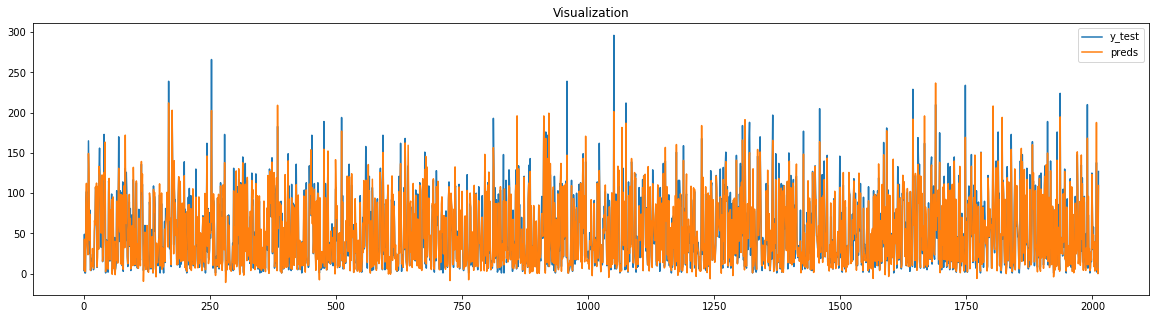

In [35]:
plt.figure(figsize=(20,5))

plt.plot(y_test, label='y_test')
plt.plot(preds, label='preds')
plt.title('Visualization')
plt.legend()
plt.show()

In [36]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 11.853444


In [37]:
def mape(label, pred):

    return np.mean(np.abs(label - pred).astype(np.float64) / label)

In [38]:
test_err = mape(y_test, preds)
print ("MAPE: %f" % (test_err))

MAPE: 0.364782


In [39]:
test_df = avg_volume_test.copy()
test_df = convert_dataframe(test_df)
test_df.head()

,tollgate_id,direction,volume,month,day,weekday,hour,minute,holiday
0,3,0,12,10,18,1,0,0,0
1,3,1,148,10,18,1,0,0,0
2,1,0,11,10,18,1,0,0,0
3,1,1,105,10,18,1,0,0,0
4,3,0,12,10,18,1,0,20,0


In [40]:
test_label = test_df['volume'].values
test_df.drop(['volume'], axis=1, inplace=True)

In [41]:
test_label.shape

(2445,)

In [42]:
test_df.head()

,tollgate_id,direction,month,day,weekday,hour,minute,holiday
0,3,0,10,18,1,0,0,0
1,3,1,10,18,1,0,0,0
2,1,0,10,18,1,0,0,0
3,1,1,10,18,1,0,0,0
4,3,0,10,18,1,0,20,0


In [43]:
test_preds = xg_reg.predict(test_df)

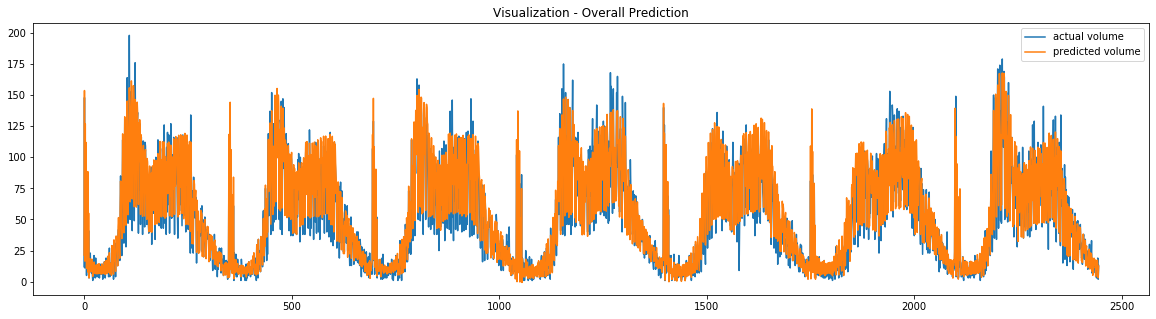

In [44]:
plt.figure(figsize=(20,5))

plt.plot(test_label, label='actual volume')
plt.plot(test_preds, label='predicted volume')
plt.title('Visualization - Overall Prediction')
plt.legend()
plt.show()

In [45]:
test_err = mape(test_label, test_preds)
print ("MAPE: %f" % (test_err))

MAPE: 0.280261


In [46]:
# Excluding Holiday data from training set
train_df = avg_volume_train.copy()
train_df = convert_dataframe(train_df)
train_df.shape

(10063, 9)

In [47]:
train_df_exclude_holiday = train_df[train_df.holiday == 0]
train_df_exclude_holiday.shape

(7684, 9)

In [48]:
train_df_exclude_holiday_label = train_df_exclude_holiday['volume'].values
train_df_exclude_holiday.drop(['volume'], axis=1, inplace=True)

D:\anaconda\conda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [49]:
X_train, X_test, y_train, y_test = train_test_split(train_df_exclude_holiday, train_df_exclude_holiday_label, test_size=0.2, random_state=123)

In [50]:
data_dmatrix = xgb.DMatrix(data=train_df_exclude_holiday,label=train_df_exclude_holiday_label)

xg_reg = xgb.XGBRegressor(objective ='reg:linear', eta = 0.02, min_child_weight = 8,
                subsample = 0.9, colsample_bytree = 0.8, max_depth = 8,
                seed=1, silent=1)

In [51]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [52]:
test_err = mape(y_test, preds)
print ("MAPE: %f" % (test_err))

MAPE: 0.253194


In [53]:
test_df = avg_volume_test.copy()
test_df = convert_dataframe(test_df)

test_label = test_df['volume'].values
test_df.drop(['volume'], axis=1, inplace=True)

In [54]:
test_preds = xg_reg.predict(test_df)

In [ ]:
plt.figure(figsize=(20,5))

plt.plot(test_label, label='actual volume')
plt.plot(test_preds, label='predicted volume')
plt.title('Visualization - Overall Prediction - Excluded Holidays from Training Data')
plt.legend()
plt.show()

In [ ]:
test_err = mape(test_label, test_preds)
print ("MAPE: %f" % (test_err))

In [ ]:
# Checking on the rush hour periods
test_df = avg_volume_test.copy()
test_df = convert_dataframe(test_df)
test_df['preds'] = test_preds

test_df_rush_hour = test_df[((test_df['hour'] >= 8) & (test_df['hour'] < 10)) | ((test_df['hour'] >= 17) & (test_df['hour'] < 19))]
test_df_rush_hour.shape

In [ ]:
test_df_rush_hour.head()

In [ ]:
test_df_rush_hour.tail()

In [ ]:
plt.figure(figsize=(20,5))

plt.plot(test_df_rush_hour['volume'].values, label='actual volume')
plt.plot(test_df_rush_hour['preds'].values, label='predicted volume')
plt.title('Visualization - Rush Hours')
plt.legend()
plt.show()

In [ ]:
test_err = mape(test_df_rush_hour['volume'].values, test_df_rush_hour['preds'].values)
print ("MAPE: %f" % (test_err))

# Incorporate with Weather Data

In [ ]:
# Extract month/day/dayofweek/hour/minute/holiday features from time window
# Reference from: https://github.com/chenzeyuczy/KDD2017/blob/master/code/load_data.py

def parse_weather_data(filename):
    df = pd.read_csv(filename)

    df['time_window'] = pd.to_datetime(df.apply(lambda x: "{} {:02}".format(x.date, x.hour), axis=1))
    # Fix errors at wind_direction.
    df['wind_direction'] = df['wind_direction'].apply(lambda x: x % 360)
    df.drop(['date', 'hour'], axis=1, inplace=True)
    df.set_index('time_window', inplace=True)

    return df

In [ ]:
# Load Weather Training Dataset
file_suffix = '.csv'
path = '../data/dataSets/training/'
filename = 'weather (table 7)_training'

weather_file = path + filename + file_suffix
weather_training = parse_weather_data(weather_file)
weather_training.head()

In [ ]:
# Load Weather Testing Dataset
file_suffix = '.csv'
path = '../data/dataSets/testing_phase1/'
filename = 'weather (table 7)_test1'

weather_file = path + filename + file_suffix
weather_testing = parse_weather_data(weather_file)
weather_testing.head()

In [ ]:
def get_mean_data(weather_data):
    mean_data = {}
    keys = ['pressure', 'sea_pressure', 'wind_direction', 'wind_speed',
        'temperature', 'rel_humidity', 'precipitation']
    for key in keys:
        mean_data[key] = weather_data[key].mean()
    return mean_data

In [ ]:
# Calculate Mean Weather Data to fill NaN values

weather_data = pd.concat([weather_training, weather_testing])
mean_weather = get_mean_data(weather_data)

In [ ]:
train_df = avg_volume_train.copy()
time_window = train_df['time_window'].values
train_df = convert_dataframe(train_df)
train_df['time_window'] = time_window # Use time window to join with weather data
train_df.head()

In [ ]:
# Weather data has time window = 3 hours
train_df['date_time'] = train_df.time_window.apply(lambda x: x - pd.Timedelta(hours=x.hour % 3, minutes=x.minute))
train_df.head()

In [ ]:
train_df = train_df.join(weather_training, on='date_time', how='left')
train_df.head()

In [ ]:
# Fill nan in dataframe.
weather_columns = ['pressure', 'sea_pressure', 'precipitation', 'rel_humidity', 'temperature', 'wind_direction', 'wind_speed']
for column in weather_columns:
    train_df[column].fillna(mean_weather[column], inplace=True)

In [ ]:
# Remove joint points
train_df = train_df.drop(columns=['time_window','date_time'])

In [ ]:
train_df.shape

In [ ]:
train_label = train_df['volume'].values
train_df.drop(['volume'], axis=1, inplace=True)

In [ ]:
train_df_exclude_holiday = train_df[train_df.holiday == 0]
train_df_exclude_holiday.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df_exclude_holiday, train_df_exclude_holiday_label, test_size=0.2, random_state=123)

In [ ]:
data_dmatrix = xgb.DMatrix(data=train_df_exclude_holiday,label=train_df_exclude_holiday_label)

xg_reg = xgb.XGBRegressor(objective ='reg:linear', eta = 0.02, min_child_weight = 8,
                subsample = 0.9, colsample_bytree = 0.8, max_depth = 8,
                seed=1, silent=1)

xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

In [ ]:
test_err = mape(y_test, preds)
print ("MAPE: %f" % (test_err))

In [ ]:
test_df = avg_volume_test.copy()
time_window = test_df['time_window'].values
test_df = convert_dataframe(test_df)
test_df['time_window'] = time_window # Use time window to join with weather data
test_df.head()

In [ ]:
test_df['date_time'] = test_df.time_window.apply(lambda x: x - pd.Timedelta(hours=x.hour % 3, minutes=x.minute))
test_df.head()

In [ ]:
test_df = test_df.join(weather_testing, on='date_time', how='left')
test_df.head()

In [ ]:
test_label = test_df['volume'].values
test_df.drop(['volume'], axis=1, inplace=True)

In [ ]:
# Fill nan in dataframe.
weather_columns = ['pressure', 'sea_pressure', 'precipitation', 'rel_humidity', 'temperature', 'wind_direction', 'wind_speed']
for column in weather_columns:
    test_df[column].fillna(mean_weather[column], inplace=True)

In [ ]:
# Remove joint points
test_df = test_df.drop(columns=['time_window','date_time'])

In [ ]:
test_df.shape

In [ ]:
test_preds = xg_reg.predict(test_df)

In [ ]:
test_err = mape(test_label, test_preds)
print ("MAPE: %f" % (test_err))

In [ ]:
# Checking on the rush hour periods
test_df = avg_volume_test.copy()
test_df = convert_dataframe(test_df)
test_df['preds'] = test_preds

test_df_rush_hour = test_df[((test_df['hour'] >= 8) & (test_df['hour'] < 10)) | ((test_df['hour'] >= 17) & (test_df['hour'] < 19))]

plt.figure(figsize=(20,5))

plt.plot(test_df_rush_hour['volume'].values, label='actual volume')
plt.plot(test_df_rush_hour['preds'].values, label='predicted volume')
plt.title('Visualization - with Weather - Rush Hours')
plt.legend()
plt.show()

In [ ]:
test_err = mape(test_df_rush_hour['volume'].values, test_df_rush_hour['preds'].values)
print ("MAPE: %f" % (test_err))